<a href="https://colab.research.google.com/github/piyush-an/INFO7374_Predict_StockPrice/blob/main/3_Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part - 3: Visualize the feature importance and feature selection process
- Regression based approach, such as Ridge regression, LASSO, Elastic Net or LARS

    `vs`

- Decision tree based approach (random forest, XGBoost)

## Importing libraries

In [95]:
%%bash

pip install pandas yfinance ta seaborn matplotlib pandas-datareader jinja2 fredapi openpyxl xgboost scikit-learn statsmodels mlflow

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import math
from xgboost import XGBRegressor
import math
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (15, 20)

## MLFlow Experiment Tracking

In [97]:
import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "http://mlflow.anandpiyush.com"
SET_EXPERIMENT = "INFO7374_team_nvdia"
EXPERIMENT_ID = "5"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(SET_EXPERIMENT)
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
mlflow.sklearn.autolog(silent=True)
mlflow.xgboost.autolog(silent=True)
mlflow.statsmodels.autolog()

## Train & Test Data Split

In [98]:
nvda = pd.read_csv("https://raw.githubusercontent.com/piyush-an/INFO7374_Predict_StockPrice/main/NVDA_feature_mart.csv")
nvda.set_index("Unnamed: 0", inplace=True)

nvda.index = pd.to_datetime(nvda.index)
nvda = nvda[nvda.index >= pd.to_datetime("2022-01-01")]
split_date = pd.to_datetime("2023-07-31")

df_train = nvda[nvda.index <= split_date]
df_test = nvda[nvda.index > split_date]

print(f"Number of rows in df_train: {len(df_train)}")
print(f"Number of rows in df_test: {len(df_test)}")

columns_to_keep = []
columns_to_drop = ["Open", "High", "Low", "Typical_Price"]

X_train = df_train.loc[:, df_train.columns != "Close"][:-1]
X_train = X_train.drop(columns_to_drop, axis=1)
y_train = df_train["Close"].shift(-1)[:-1]

X_test = df_test.loc[:, df_test.columns != "Close"][:-1]
X_test = X_test.drop(columns_to_drop, axis=1)
y_test = df_test["Close"].shift(-1)[:-1]

Number of rows in df_train: 393
Number of rows in df_test: 64


## Elastic Net

In [99]:
with mlflow.start_run():
    model = ElasticNet(alpha=1.0, fit_intercept=False).fit(X_train, y_train)
    selected_columns = X_train.columns[np.abs(model.coef_) >= 0.001]
    X_train_selected = X_train[selected_columns]
    X_test_selected = X_test[selected_columns]

    # Fit an OLS model on the selected features
    EN_Model = sm.OLS(y_train, sm.add_constant(X_train_selected)).fit()
    y_pred = EN_Model.predict(sm.add_constant(X_test_selected))

    # Calculate RMSE
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = math.sqrt(MSE)

    # Log metrics and tag the model
    mlflow.set_tag("model", "ElasticNet")
    mlflow.set_tag("runtype", "FeatureSelection")
    mlflow.log_metric("RMSE", RMSE)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e+04, tolerance: 2.314e+03
  model = cd_fast.enet_coordinate_descent(


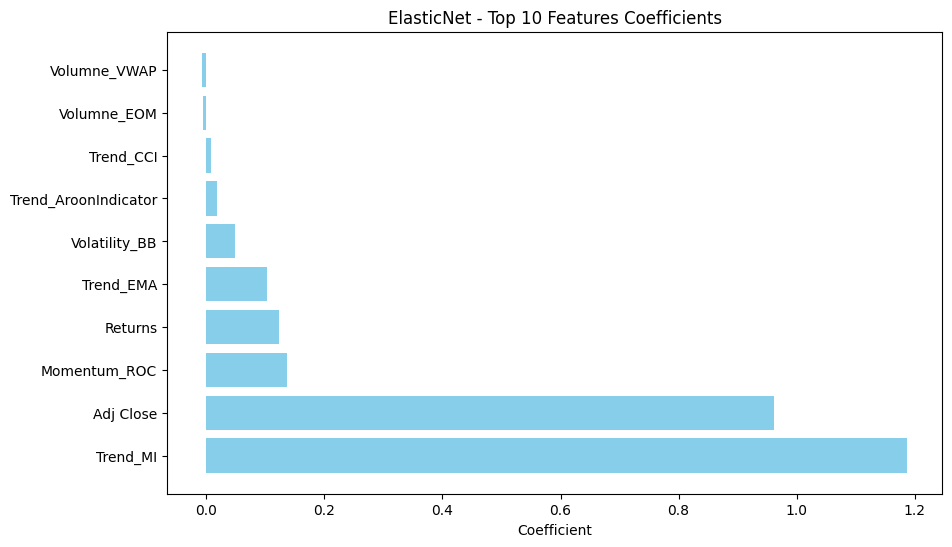

In [100]:
coefficients = EN_Model.params[1:]
feature_names = X_train_selected.columns

# Create a DataFrame with feature names and coefficients
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False).head(10)

# Plot the top 10 significant features
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('ElasticNet - Top 10 Features Coefficients')
plt.show()

## Least Angle Regression (LARS)

In [101]:
with mlflow.start_run():
    model = Lasso(alpha=0.5, fit_intercept=False).fit(X_train, y_train)
    selected_columns = X_train.columns[np.abs(model.coef_) >= 0.001]
    X_train_selected = X_train[selected_columns]
    X_test_selected = X_test[selected_columns]

    LARS_Model = sm.OLS(y_train, sm.add_constant(X_train_selected)).fit()
    y_pred = LARS_Model.predict(sm.add_constant(X_test_selected))
    corr_model = np.corrcoef(y_pred, y_test, rowvar=False)[0, 1]

    MSE = mean_squared_error(y_test, y_pred)
    RMSE = math.sqrt(MSE)

    print(LARS_Model.summary())

    mlflow.set_tag("model", "LARS")
    mlflow.set_tag("runtype", "FeatureSelection")
    mlflow.log_metric("RMSE", RMSE)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.412e+04, tolerance: 2.314e+03
  model = cd_fast.enet_coordinate_descent(


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2251.
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        08:25:28   Log-Likelihood:                -1384.5
No. Observations:                 392   AIC:                             2807.
Df Residuals:                     373   BIC:                             2882.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    51.83

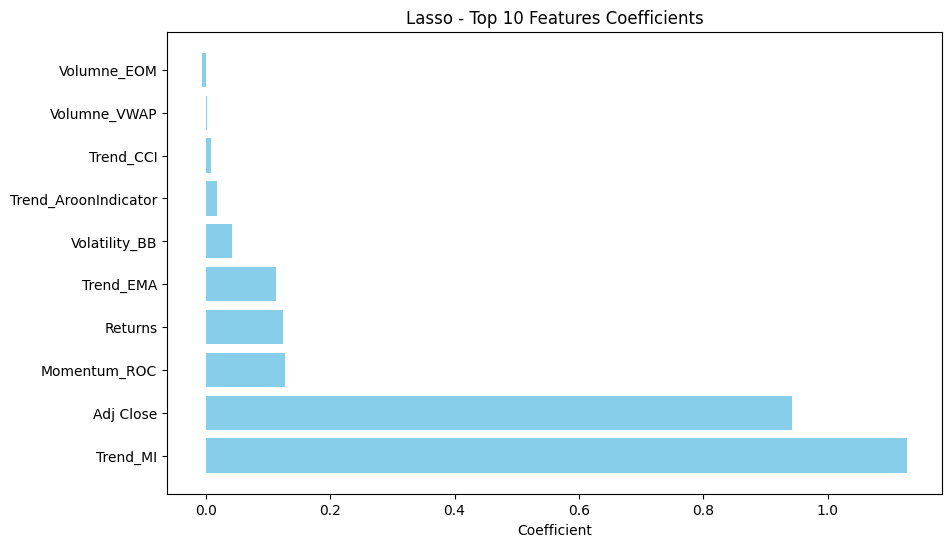

In [102]:
# Extract coefficients and their names
coefficients = LARS_Model.params[1:]
feature_names = X_train_selected.columns

# Create a DataFrame with feature names and coefficients
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False).head(10)

# Plot the top 10 significant features
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Lasso - Top 10 Features Coefficients')
plt.show()

## Ordinary Least Squares (OLS) Regression

In [103]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

with mlflow.start_run():
    OLS_Model = sm.OLS(y_train, X_train_const).fit()
    print(OLS_Model.summary())
    y_pred = OLS_Model.predict(X_test_const)

    MSE = mean_squared_error(y_test, y_pred, squared=False)
    RMSE = math.sqrt(MSE)

    mlflow.set_tag("model", "OLS")
    mlflow.set_tag("runtype", "FeatureSelection")
    mlflow.log_metric("RMSE", RMSE)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     896.0
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        08:25:32   Log-Likelihood:                -1370.9
No. Observations:                 392   AIC:                             2834.
Df Residuals:                     346   BIC:                             3016.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

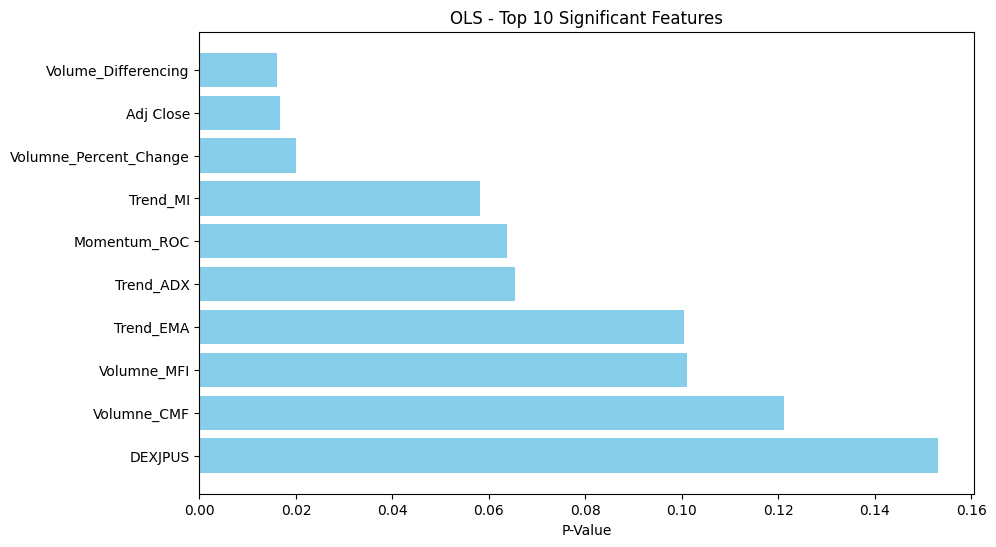

In [104]:
p_values = OLS_Model.pvalues[1:]
feature_names = X_train.columns

p_values_df = pd.DataFrame({'Feature': feature_names, 'P-Value': p_values})
p_values_df = p_values_df.sort_values(by='P-Value').head(10)

plt.figure(figsize=(10, 6))
plt.barh(p_values_df['Feature'], p_values_df['P-Value'], color='skyblue')
plt.xlabel('P-Value')
plt.title('OLS - Top 10 Significant Features')
plt.gca().invert_yaxis()
plt.show()

## XGBoost

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XgBoost - RSME = 4.639277849517546


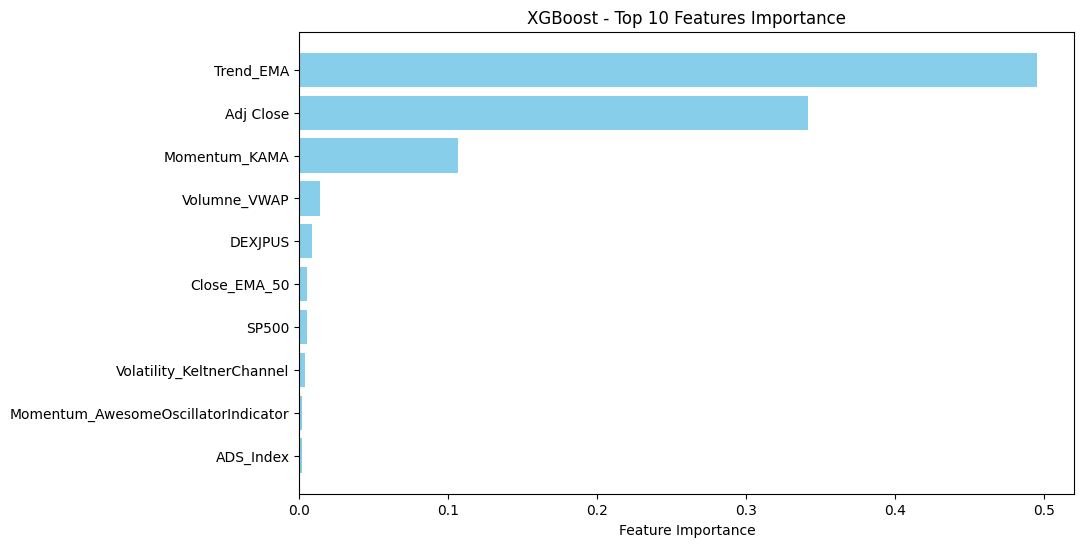

In [105]:
with mlflow.start_run():
  model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
  model.fit(
      X_train,
      y_train,
      eval_metric="rmse")

  y_pred = model.predict(X_test)
  MSE = mean_squared_error(y_test, y_pred, squared=False)
  RMSE = math.sqrt(MSE)
  mlflow.set_tag("model", "XGBoost")
  mlflow.set_tag("runtype", "FeatureSelection")
  mlflow.log_metric("RMSE", RMSE)
  print(f"XgBoost - RSME = {RMSE}")

# Get feature importances from XGBoost model
feature_importance = pd.DataFrame(model.feature_importances_,
                                  index=X_train.columns,
                                  columns=['feature importance'])

# Sort features by importance and select top 10
top_10_features = feature_importance.nlargest(10, 'feature importance')

# Plotting top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features.index, top_10_features['feature importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('XGBoost - Top 10 Features Importance')
plt.gca().invert_yaxis()
plt.show()
